In [5]:
import csv
import os
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
sys.path.append('../../../Lib/PythonML')

from linear import Linear
from multicouche import MLP
from svm import SVM 
from random import randrange
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D

In [13]:
frequency_max = 12000
frequency_precision = 1
labels = ['guitare','saxo', 'piano']
dll_path = '../../../Lib/SupervisingML/target/debug/libmllib_rust.so'
train_max_by_label = 40
use_real_dataset = True
if use_real_dataset:
    train_path = '../../../Dataset/Train/Fourier'
    validation_path = '../../../Dataset/Test/Fourier'
else:
    train_path = '../Fourier/dataset/train'
    validation_path = '../Fourier/dataset/validation'

In [14]:
def getCsvData(path):
    with open(path, newline='\n') as f:
        reader = csv.reader(f, delimiter=';')
        next(reader, None)
        data = [] 
        count = 0
        #0,1 -> 0 2,3 -> 1 4,5 -> 2
        for row in reader:
            if len(data) == (frequency_max * 2 * frequency_precision):
                break
                
            frequency = float(row[0])
            if frequency > frequency_max:
                break
            if int(frequency) * 2 + 1 < count:
                continue
            count += 1
            data.append([float(row[0]), float(row[1])])
       
        return data

def importData(path, label_number = len(labels), max_by_label = -1):
    data = []
    label = []
    if label_number > len(labels):
        label_number = len(labels)
    for i in range(label_number):
        data_count_by_label = 0
        directory_path = os.path.join(path, labels[i])
        for r, _, f in os.walk(directory_path):
            for file in f:
                if data_count_by_label == max_by_label and max_by_label != -1:
                    break
                data.append(getCsvData(os.path.join(directory_path, file)))
                if i == 0 and label_number == 2:
                    label.append(-1)
                else:
                    label.append(i)
                data_count_by_label += 1
    print(data)
    print(label)
    return (np.array(data, dtype='float64'), np.array(label, dtype='float64'))

def shuffle(data,label):
    for i in range(len(label)):
        rand = random.randrange(i,len(label))
        label[i], label[rand] = label[rand], label[i]
        data[i], data[rand] = data[rand], data[i]
    return (data,label)

def test(data, label):
    good_predict = [0,0]
    number_of_predict = [0,0]
    for i in range(len(data)):
        predicted_value = linear.predict_linear_model_classification(data[i])
        if label[i] == -1.0:
            number_of_predict[0] += 1
            if predicted_value == -1.0:
                good_predict[0] += 1
        else:
            number_of_predict[1] += 1
            if predicted_value == 1.0:
                good_predict[1] += 1
    return (good_predict, number_of_predict)

#def fit_folder(path):

In [15]:
train_data, train_label = importData(train_path, 2, train_max_by_label)
validation_data, validation_label = importData(validation_path, 2, train_max_by_label)
print("Import Finish")

train_data, train_label = shuffle(train_data, train_label)
validation_data, validation_label = shuffle(validation_data, validation_label)  

data = np.concatenate([train_data, validation_data])
label = np.concatenate([train_label, validation_label])

print(train_data.shape)
print(train_label.shape)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Keras : Linear Model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 48000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 48001     
Total params: 48,001
Trainable params: 48,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3/3 [==============================] - 0s 32ms/step - loss: -1.2818e-09 - val_loss: 1.0837e-08
Epoch 2/100
3/3 [==============================] - 0s 20ms/step - loss: -1.2818e-09 - val_loss: 1.0837e-08
Epoch 3/100
3/3 [==============================] - 0s 13ms/step - loss: -1.2818e-09 - val_loss: 1.0837e-08
Epoch 4/100
3/3 [==============================] - 0s 13ms/step - loss: -1.2818e-09 - val_loss: 1.0837e-08
Epoch 5/100
3/3 [==============================] - 0s 13ms/step - loss: -1.2818e-09 

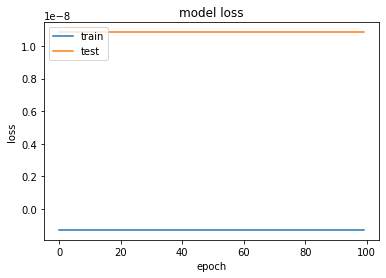

In [12]:
'''
train_label_categorical = to_categorical(train_label)
train_data_categorical = to_categorical(train_data)
'''

model = Sequential()
model.add(keras.layers.Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(1, activation='tanh'))
model.summary()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')
history = model.fit(data, label, validation_split = 0.1, epochs= 100)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Rust lib : Linear Model

In [22]:
linear = Linear(dll_path)
linear.init_linear_model(frequency_max * 2 * frequency_precision * 2)
linear.train_linear_model_classification(train_data.flatten(), train_label.flatten(), len(train_label), 10000, 0.03)

good_predict, number_of_predict = test(validation_data, validation_label)
#print("predicted result : " + str(predicted_value) + " / result : " + str(validation_label[i]))
print("Test :")
print("Predict of -1.0 : " + str(good_predict[0]) + " of " + str(number_of_predict[0]))
print("Predict of 1.0 : " + str(good_predict[1]) + " of " + str(number_of_predict[1]))

good_predict, number_of_predict = test(train_data, train_label)
print("Train :")
print("Predict of -1.0 : " + str(good_predict[0]) + " of " + str(number_of_predict[0]))
print("Predict of 1.0 : " + str(good_predict[1]) + " of " + str(number_of_predict[1]))

Test :
Predict of -1.0 : 10 of 12
Predict of 1.0 : 1 of 12
Train :
Predict of -1.0 : 31 of 40
Predict of 1.0 : 26 of 40


In [ ]:
train_data, train_label = importData('../Fourier/dataset/train', 3, train_max_by_label)
validation_data, validation_label = importData('../Fourier/dataset/validation', 3)
print("Import Finish")

train_data, train_label = shuffle(train_data, train_label)
validation_data, validation_label = shuffle(validation_data, validation_label)  

data = np.concatenate([train_data, validation_data])
label = np.concatenate([train_label, validation_label])

print(train_data.shape)
print(train_label.shape)

## Keras : MLP Model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 48000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 12)                576012    
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 39        
Total params: 576,051
Trainable params: 576,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 0s 81ms/step - loss: 34555.0781 - accuracy: 0.3380 - val_loss: 22013.4434 - val_accuracy: 0.3125
Epoch 2/100
5/5 [==============================] - 0s 24ms/step - loss: 32115.7773 - accuracy: 0.3380 - val_loss: 1.0986 - val_accuracy: 0.3125
Epoch 3/100
5/5 [==============================] - 0s 46ms/step - loss: 1.0986 - accur

Epoch 54/100
5/5 [==============================] - 0s 45ms/step - loss: 1.0986 - accuracy: 0.3310 - val_loss: 1.0986 - val_accuracy: 0.3125
Epoch 55/100
5/5 [==============================] - 0s 45ms/step - loss: 1.0986 - accuracy: 0.3310 - val_loss: 1.0986 - val_accuracy: 0.3125
Epoch 56/100
5/5 [==============================] - 0s 39ms/step - loss: 1.0986 - accuracy: 0.3310 - val_loss: 1.0986 - val_accuracy: 0.3125
Epoch 57/100
5/5 [==============================] - 0s 42ms/step - loss: 1.0986 - accuracy: 0.3310 - val_loss: 1.0986 - val_accuracy: 0.3125
Epoch 58/100
5/5 [==============================] - 0s 45ms/step - loss: 1.0986 - accuracy: 0.3310 - val_loss: 1.0986 - val_accuracy: 0.3125
Epoch 59/100
5/5 [==============================] - 0s 35ms/step - loss: 1.0986 - accuracy: 0.3310 - val_loss: 1.0986 - val_accuracy: 0.3125
Epoch 60/100
5/5 [==============================] - 0s 40ms/step - loss: 1.0986 - accuracy: 0.3310 - val_loss: 1.0987 - val_accuracy: 0.3125
Epoch 61/100


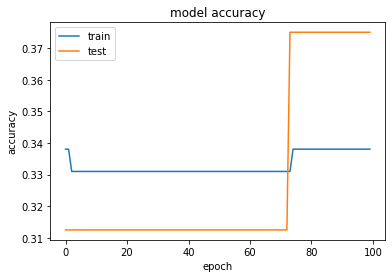

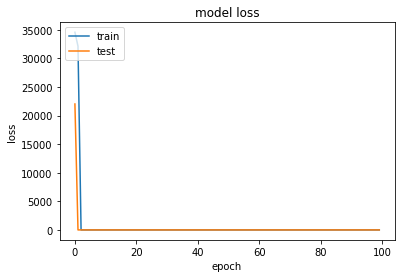

In [36]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=data.shape[1:]),
    keras.layers.Dense(12, activation='relu'),
    keras.layers.Dense(3)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
history = model.fit(data, label, validation_split = 0.1, epochs=100)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Keras : MLP Model

In [ ]:
mlp = MLP(dll_path)
mlp.init_multicouche_model(np.array([train_data.shape[1] * train_data.shape[2],1], dtype='float64'))
mlp.train_multicouche_model_classification(train_data.flatten(), train_label.flatten(), train_data.shape[0], 10000.0, 0.03)

for i in range(len(validation_data)):
    predicted_value = mlp.predict_multicouche_model_classification(validation_data)[0]
    print("predicted result : " + str(predicted_value) + " / result : " + str(validation_label[i]))